# Brewing Data Cup

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
active_promos = pd.read_csv('data/active_promos.csv')
active_promos['Fecha_Desde'] = pd.to_datetime(active_promos['Fecha_Desde'], format='%Y-%m-%d')
active_promos['Fecha_Hasta'] = pd.to_datetime(active_promos['Fecha_Hasta'], format='%Y-%m-%d')
active_promos['dias_promo'] = (active_promos['Fecha_Hasta']-active_promos['Fecha_Desde']).dt.days.astype('int64')
active_promos['Fecha_Desde'] = active_promos.Fecha_Desde.dt.year*100+active_promos.Fecha_Desde.dt.month
active_promos['Fecha_Hasta'] = active_promos.Fecha_Hasta.dt.year*100+active_promos.Fecha_Hasta.dt.month
active_promos['duracion'] = active_promos['Fecha_Hasta']-active_promos['Fecha_Desde']

executed_promos = pd.read_csv('data/executed_promos.csv')

clients = pd.read_csv('data/clients_attributes.csv')
clients['FechaAltaCliente'] = pd.to_datetime(clients['FechaAltaCliente'], format='%Y-%m-%d')
clients['FechaAltaCliente'] = clients.FechaAltaCliente.dt.year*100+clients.FechaAltaCliente.dt.month

sales = pd.read_csv('data/sales.csv',encoding='ISO-8859-1')
sales = sales.dropna()
sales['fecha'] = sales.Año*100+sales.Mes
sales.drop(columns=['Año','Mes'],inplace=True)

test = pd.read_csv('data/test.csv')

In [3]:
executed_promos['target'] = 1
df = active_promos.merge(executed_promos,on=['CodigoDC','Cliente','Marca','Cupo'],how='left').replace(np.nan,0)

In [4]:
rechazados = []
agr = {'target':['count','sum','mean']}
ext = []
agre = {'CodigoDC':'nunique','duracion':'mean'}

for i in list(df.Fecha_Desde.unique()):
    aux = df[df.Fecha_Hasta < i].groupby(['Cliente','Marca','Cupo']).agg(agr)
    aux.columns = [j+'_'+k for j,k in aux.columns]
    aux['prom_rechazo'] = aux['target_count'] - aux['target_sum']
    aux.drop(columns=['target_count','target_sum'],inplace=True)
    aux['Fecha_Desde'] = i
    rechazados.append(aux)
    
    aux2 = df[df.Fecha_Desde == i].groupby(['Cliente','Marca','Cupo']).agg(agre)
    aux2.columns = ['nproms_ofre','duracion_mes_mean']
    aux2['Fecha_Desde'] = i
    ext.append(aux2)
    
hist_rech = pd.concat(rechazados)
agre_1 = pd.concat(ext)
df = df.merge(hist_rech,on=['Cliente','Marca','Cupo','Fecha_Desde'],how='left')
df = df.merge(agre_1,on=['Cliente','Marca','Cupo','Fecha_Desde'],how='left')
df = df.replace(np.nan,0)

In [5]:
adi = []
agreg = {'CodigoDC':'nunique',
           'target':['max','mean'],
           'Fecha_Desde':'nunique',
           'target_mean':['max','mean'],
           'dias_promo':['mean','max','min','std']}

for i in list(df.Fecha_Desde.unique()):
    aux3 = df[df.Fecha_Desde<i].groupby(['Cliente','Marca','Cupo']).agg(agreg)
    aux3.columns = [j+'_'+k for j,k in aux3.columns]
    aux3['Fecha_Desde'] = i
    aux3 = aux3.reset_index()
    adi.append(aux3)
    
agre_2 = pd.concat(adi)
df = df.merge(agre_2,on=['Cliente','Marca','Cupo','Fecha_Desde'],how='left')
df = df.replace(np.nan,0)
#df

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc442c82a50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc442c90310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc442c82610>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc442c90bd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc442c99050>],
 'means': []}

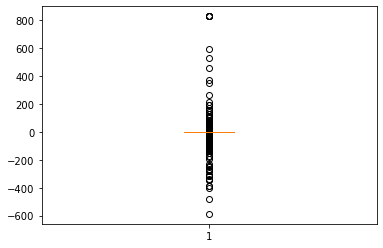

In [6]:
sales['riesgo_producto'] = (sales['Dcto'] / sales['Nr'])
sales.riesgo_producto = sales.riesgo_producto.fillna(0)
sales = sales.drop(sales[sales.riesgo_producto < -600].index)
sales = sales.drop(sales[sales.riesgo_producto > 1000].index)
plt.boxplot(sales.riesgo_producto)

In [7]:
master = []
ad = {'Hl':['sum','min','max','mean'],
     'Dcto':['sum','min','max','mean'],
     'Nr':['sum','min','max','mean']}

for i in list(df.Fecha_Desde.unique()):
    temp = sales[(sales.fecha<i)].groupby(['Cliente']).agg(ad)
    temp.columns = [str(j)+'_'+str(k) for j,k in temp.columns]
    temp['Fecha_Desde'] = i # Acumulado de ventas hasta antes de la Fecha_Desde de la promo
    master.append(temp)
acum_cliente = pd.concat(master).reset_index()
df = df.merge(acum_cliente,on=['Cliente','Fecha_Desde'],how='left')

In [8]:
df = df.merge(clients,on=['Cliente'],how='left')
df.head()

,CodigoDC,Marca,Cupo,Fecha_Desde,Fecha_Hasta,Cliente,dias_promo,duracion,target,target_mean_x,prom_rechazo,nproms_ofre,duracion_mes_mean,CodigoDC_nunique,target_max,target_mean_y,Fecha_Desde_nunique,target_mean_max,target_mean_mean,dias_promo_mean,dias_promo_max,dias_promo_min,dias_promo_std,Hl_sum,Hl_min,Hl_max,Hl_mean,Dcto_sum,Dcto_min,Dcto_max,Dcto_mean,Nr_sum,Nr_min,Nr_max,Nr_mean,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,297601,29,9,201808,201808,3213,24,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,0.01,0.62,0.096154,-128346.89,-22086.67,0.0,-1234.104712,3053627.15,3092.91,178134.55,29361.799519,201003,3,8,15,2,3,1
1,297601,29,9,201808,201808,3795,24,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.99,0.03,0.98,0.203878,-248783.11,-70273.24,0.0,-5077.206327,3378290.77,-13347.44,284888.42,68944.709592,201004,3,10,6,2,3,1
2,297601,29,9,201808,201808,11816,24,0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.44,0.01,7.13,0.576667,-452013.07,-137887.73,0.0,-5381.107976,14853188.88,1533.96,2199023.28,176823.677143,201710,3,7,12,2,3,1
3,298856,40,16,201808,201808,8444,7,0,1.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.37,0.01,1.08,0.191890,-802059.92,-50638.85,0.0,-6315.432441,5616765.42,604.52,245902.45,44226.499370,201509,5,27,18,2,2,1
4,309916,40,16,201808,201808,8488,7,0,1.0,0.0,0.0,2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.65,0.00,4.25,0.315487,-746163.91,-109898.11,0.0,-6603.220442,10892596.84,2194.04,1309385.05,96394.662301,201509,3,10,16,2,2,0


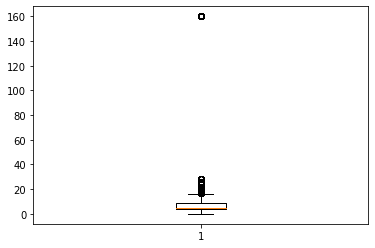

In [9]:
plt.boxplot(active_promos.dias_promo)
active_promos = active_promos.drop(active_promos[active_promos.dias_promo > 20].index)

In [10]:
df['Marca_Cupo']=df['Marca']*100+df['Cupo']

In [11]:
df=df.drop(columns='FechaAltaCliente')

In [12]:
df.drop(columns=['CodigoDC'],inplace=True)

In [13]:
train = df[df.Fecha_Desde<201908]
te = df[df.Fecha_Desde>=201908]

In [14]:
columnas_train=[x for x in train.columns if x!='target']
X_train,X_test,y_train,y_test=train[columnas_train],te[columnas_train],train['target'],te['target']

In [15]:
from catboost import CatBoostClassifier

In [16]:
model=CatBoostClassifier(n_estimators=400)
model.fit(X_train,y_train)

Learning rate set to 0.292742
0:	learn: 0.3976563	total: 94.4ms	remaining: 37.7s
1:	learn: 0.2850120	total: 129ms	remaining: 25.6s
2:	learn: 0.2428191	total: 163ms	remaining: 21.6s
3:	learn: 0.2122219	total: 209ms	remaining: 20.7s
4:	learn: 0.2040088	total: 250ms	remaining: 19.7s
5:	learn: 0.1998387	total: 286ms	remaining: 18.8s
6:	learn: 0.1972840	total: 326ms	remaining: 18.3s
7:	learn: 0.1957188	total: 361ms	remaining: 17.7s
8:	learn: 0.1936268	total: 398ms	remaining: 17.3s
9:	learn: 0.1905543	total: 442ms	remaining: 17.2s
10:	learn: 0.1895516	total: 483ms	remaining: 17.1s
11:	learn: 0.1883723	total: 523ms	remaining: 16.9s
12:	learn: 0.1878930	total: 562ms	remaining: 16.7s
13:	learn: 0.1870290	total: 600ms	remaining: 16.5s
14:	learn: 0.1863949	total: 636ms	remaining: 16.3s
15:	learn: 0.1855186	total: 679ms	remaining: 16.3s
16:	learn: 0.1849829	total: 718ms	remaining: 16.2s
17:	learn: 0.1845586	total: 756ms	remaining: 16s
18:	learn: 0.1827430	total: 800ms	remaining: 16.1s
19:	learn: 0

162:	learn: 0.1614402	total: 6.57s	remaining: 9.56s
163:	learn: 0.1613823	total: 6.61s	remaining: 9.51s
164:	learn: 0.1610172	total: 6.65s	remaining: 9.47s
165:	learn: 0.1609595	total: 6.69s	remaining: 9.43s
166:	learn: 0.1609323	total: 6.72s	remaining: 9.38s
167:	learn: 0.1608874	total: 6.76s	remaining: 9.34s
168:	learn: 0.1608318	total: 6.81s	remaining: 9.31s
169:	learn: 0.1607691	total: 6.85s	remaining: 9.27s
170:	learn: 0.1607227	total: 6.89s	remaining: 9.23s
171:	learn: 0.1606106	total: 6.93s	remaining: 9.18s
172:	learn: 0.1605397	total: 6.97s	remaining: 9.14s
173:	learn: 0.1604381	total: 7.01s	remaining: 9.11s
174:	learn: 0.1603995	total: 7.05s	remaining: 9.07s
175:	learn: 0.1603506	total: 7.09s	remaining: 9.02s
176:	learn: 0.1603028	total: 7.13s	remaining: 8.98s
177:	learn: 0.1602584	total: 7.17s	remaining: 8.94s
178:	learn: 0.1602217	total: 7.21s	remaining: 8.89s
179:	learn: 0.1601650	total: 7.24s	remaining: 8.85s
180:	learn: 0.1600905	total: 7.29s	remaining: 8.82s
181:	learn: 

321:	learn: 0.1530913	total: 13.4s	remaining: 3.24s
322:	learn: 0.1530437	total: 13.4s	remaining: 3.2s
323:	learn: 0.1530029	total: 13.5s	remaining: 3.16s
324:	learn: 0.1529769	total: 13.5s	remaining: 3.12s
325:	learn: 0.1529429	total: 13.6s	remaining: 3.08s
326:	learn: 0.1528914	total: 13.6s	remaining: 3.04s
327:	learn: 0.1528595	total: 13.7s	remaining: 3s
328:	learn: 0.1528258	total: 13.7s	remaining: 2.96s
329:	learn: 0.1527712	total: 13.8s	remaining: 2.92s
330:	learn: 0.1527332	total: 13.8s	remaining: 2.88s
331:	learn: 0.1526959	total: 13.9s	remaining: 2.84s
332:	learn: 0.1526325	total: 13.9s	remaining: 2.8s
333:	learn: 0.1525994	total: 13.9s	remaining: 2.75s
334:	learn: 0.1525569	total: 14s	remaining: 2.71s
335:	learn: 0.1525286	total: 14s	remaining: 2.67s
336:	learn: 0.1524698	total: 14.1s	remaining: 2.63s
337:	learn: 0.1524313	total: 14.1s	remaining: 2.59s
338:	learn: 0.1524082	total: 14.2s	remaining: 2.55s
339:	learn: 0.1523862	total: 14.2s	remaining: 2.51s
340:	learn: 0.1523644

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
preds=model.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,preds)

0.8658509560838688

In [19]:
def plot_importances(model, X, n_features=-1):
    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    if n_features!=-1:
        indices=indices[-n_features:]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(len(X.columns[indices])), importances[indices],
           align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(len(X.columns[indices])), X.columns[indices])
    plt.ylim([-1, len(X.columns[indices])])
    plt.show()

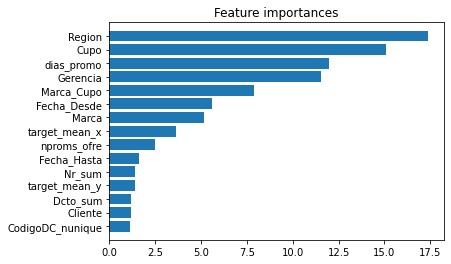

In [20]:
plot_importances(model,X_train,15)

In [21]:
sales.head()

,Cliente,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,fecha,riesgo_producto
0,1,2,2.0,44,10.0,6352.94,0.03,0.0,201801,0.00000
1,1,2,4.0,18,16.0,99130.50,0.45,0.0,201801,0.00000
2,1,2,1.0,2,6.0,11605.40,0.07,-2880.0,201806,-0.24816
3,1,1,2.0,37,34.0,1944.01,0.01,0.0,201807,0.00000
4,1,2,1.0,2,16.0,16250.18,0.06,0.0,201808,0.00000


In [22]:
clients.head()

,Cliente,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,1,200903,4,21,12,1,1,1
1,9,200903,4,21,9,2,3,1
2,15,200903,4,21,9,2,3,0
3,37,200903,4,21,16,2,3,1
4,43,200903,4,21,9,2,3,0


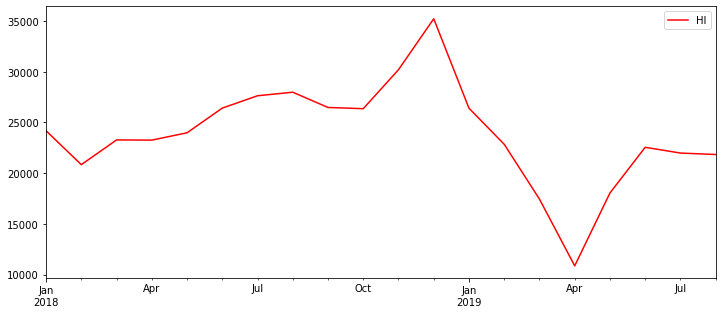

In [23]:
idx = pd.date_range('2018-01-01',periods=20,freq='MS')
ventas = sales.groupby(['fecha']).sum().reset_index()[['Hl']]
ventas.index = idx
ventas.plot(figsize=(12,5),color='r')
plt.show()

In [24]:
# Cada promo puede tener de 1 a 3 marcas en promoción
proms_mul = active_promos.groupby(['CodigoDC']).nunique().sort_values(by=['Marca','Cupo'],ascending=[False,False])
proms_mul.reset_index().groupby('Marca').count()[['CodigoDC']]

,CodigoDC
Marca,
1,12034
2,14355
3,2


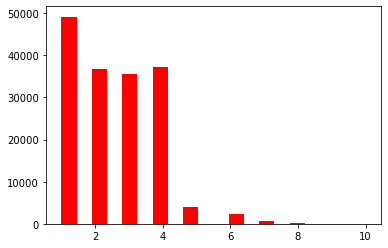

In [25]:
# Cada mes se pueden presentar varias promos para el mismo Cliente-Marca-Producto
n_promosXmes = active_promos.copy()
n_promosXmes = n_promosXmes.groupby(['Fecha_Desde','Cliente','Marca','Cupo']).nunique()
plt.hist(n_promosXmes.CodigoDC,bins=20,color='r')
plt.show()

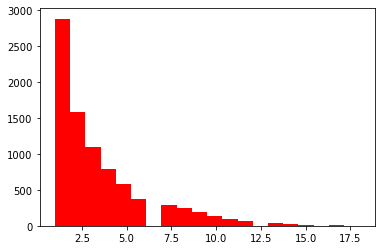

In [26]:
# Histograma de la cantidad de promos aceptadas por Cliente-Marca-Producto (1-18)
n_promos_acepXcliente = executed_promos.groupby(['Cliente','Marca','Cupo']).nunique()
plt.hist(n_promos_acepXcliente.CodigoDC,bins=20,color='r')
plt.show()

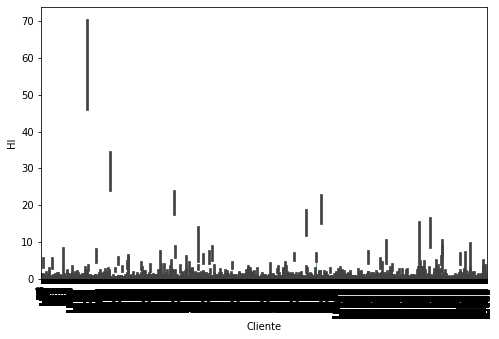

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.barplot(x='Cliente',y='Hl',data=sales)
#g.set(xlabel='',ylabel='NIV (Millones de Euros)',title='Top 20 Clientes')
plt.xticks(rotation=90)
plt.show()

In [30]:
df.groupby(['target']).mean()[['Hl_mean']]

,Hl_mean
target,
0.0,0.221889
1.0,0.307332


In [49]:
df1 = df[df.dias_promo<80]

<AxesSubplot:xlabel='Region', ylabel='Count'>

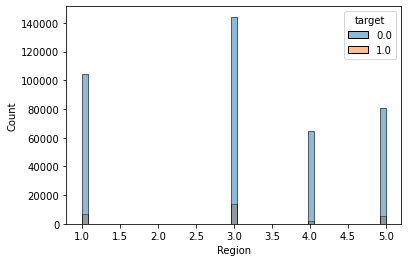

In [55]:
sns.histplot(data=df,x='Region',hue='target')

In [58]:
data = df.groupby('target')['Cliente'].count()

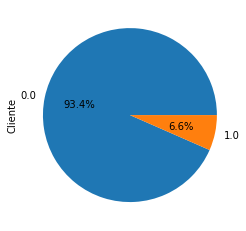

In [59]:
data.plot.pie(autopct='%.1f%%');